# **Notebook para Tesis**

Aqui hare el analisis y seleccion de caracteristicas

In [2]:
# Importar librerias necesarias

# import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Interpolación
from scipy.interpolate import PchipInterpolator

## **Lectura de Archivos**

### **Lectura Invididual**

In [3]:
folder = "/home/agustin/Documentos/Tesis/datos/40mhz/"
data_file = "brc-2002_086400-02-output.csv.gz"
label_file = "brc-2002_086400-02-output_true_labels.csv.gz"

data = pd.read_csv(folder + data_file, compression='gzip')
labels = pd.read_csv(folder + label_file, compression='gzip')

### **Lectura Total**

In [27]:
# folder = "/home/agustindelgado/Descargas/40mhz-20240520T175512Z-001/40mhz/"

# all_files = os.listdir(folder)
# data_files = [f for f in all_files if f.endswith("-output.csv.gz")]
# label_files = [f for f in all_files if f.endswith("-output_true_labels.csv.gz")]

# data_frames = []
# label_frames = []

# for data_file, label_file in zip(data_files, label_files):
#     data_frames.append(pd.read_csv(folder + data_file, compression='gzip'))
#     label_frames.append(pd.read_csv(folder + label_file, compression='gzip'))

# data = pd.concat(data_frames)
# labels = pd.concat(label_frames)

# print(data.shape)
# print(labels.shape)

### **Muestreo de Datos**

In [4]:
# Muestro los datos
print(data.head())

   Unnamed: 0  s_0  s_1  s_2  s_3  s_4  s_5  s_6  s_7  s_8  s_9  s_10  s_11  \
0          14    5    1    3    0    2    0    0    0    0    0     0     0   
1          26    0    1    0    0    0    0    0    0    0    0     0     0   
2          30   54   34   29   12    2    2    1    3    3    0     0     0   
3          31   11   10    7    6    2    0    2    0    0    0     0     0   
4          43   33   29   13    7    6    1    0    2    1    0     0     0   

   s_12  s_13  s_14  s_15  
0     0     0     0     0  
1     0     0     0     0  
2     0     0     0     0  
3     0     0     0     0  
4     0     0     0     0  


## **Interpolación**

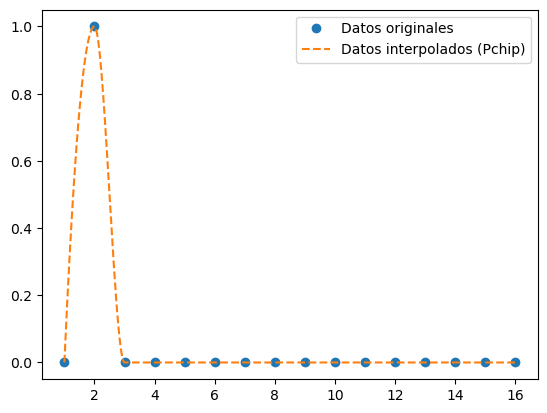

In [29]:
test = data.iloc[10, 1:].values # Tomo la segunda fila de data

x = np.arange(1, len(test)+1) 
y = test 

mask = ~np.isnan(y) # Máscara para quitar los valores NaN

# cs = CubicSpline(x[mask], y[mask]) 
p = PchipInterpolator(x[mask], y[mask]) 
xnew = np.linspace(1, len(test), num=1000)

plt.plot(x, y, 'o', label='Datos originales') 
# plt.plot(xnew, cs(xnew), '-', label='Datos interpolados (Spline Cúbico)') #Conecta los puntos pero desvia de ellos un poco 
plt.plot(xnew, p(xnew), '--', label='Datos interpolados (Pchip)') #Conecta los puntos de manera suave
plt.legend()
plt.show()

## **Features**

#### Amplitud

In [30]:
def amplitude(data):
    return np.max(data) - np.min(data)

#### Ancho de Pulso

In [31]:
def width(data, threshold=0.5):
    max_val = np.max(data)
    min_val = np.min(data)
    half_val = min_val + threshold * (max_val - min_val)
    
    # Find indices where data crosses the threshold
    above_threshold = np.where(data > half_val)[0]
    
    if len(above_threshold) == 0:
        return 0  # No points above threshold
    
    # Calculate width as the difference between the first and last index
    pulse_width = above_threshold[-1] - above_threshold[0]
    
    return pulse_width

#### Tiempo de Ascenso y Descenso

In [32]:
def rise_time(data, lower_threshold=0.15, upper_threshold=0.9):
    max_val = np.max(data)
    amplitude_10 = lower_threshold * max_val
    amplitude_90 = upper_threshold * max_val

    start_rise_index = np.argmax(data > amplitude_10)
    end_rise_index = np.argmax(data > amplitude_90)

    rise_time = end_rise_index - start_rise_index
    
    return rise_time, start_rise_index, end_rise_index

def fall_time(data, lower_threshold=0.15, upper_threshold=0.9):
    max_val = np.max(data)
    amplitude_10 = lower_threshold * max_val
    amplitude_90 = upper_threshold * max_val

    start_fall_index = len(data) - np.argmax(data[::-1] > amplitude_90) - 1  # Inicio del descenso (90%)
    end_fall_index = len(data) - np.argmax(data[::-1] > amplitude_10) - 1

    fall_time = end_fall_index - start_fall_index
    
    return fall_time, start_fall_index, end_fall_index

#### Área debajo del pulso


In [33]:
def area_under_pulse(x, y):
    return np.trapezoid(y, x)

#### Pendiente del Borde Ascendente y Descendente

In [34]:
def ascending_slope(x, y, start_index, end_index):
    dy = np.gradient(y, x)
    max_slope_index = np.argmax(dy[start_index:end_index+1])
    return dy[start_index + max_slope_index]

def descending_slope(x, y, start_index, end_index):
    dy = np.gradient(y, x)
    min_slope_index = np.argmin(dy[start_index:end_index+1])
    return dy[start_index + min_slope_index]

#### Simetria del Pulso

In [35]:
def pulse_symmetry(data, start_rise_index, end_rise_index, start_fall_index, end_fall_index):
    rise_time = end_rise_index - start_rise_index
    fall_time = end_fall_index - start_fall_index
    symmetry = rise_time / fall_time if fall_time != 0 else np.nan
    return symmetry

#### Energia del Pulso

In [36]:
def pulse_energy(x, y):
    return np.trapezoid(y**2, x)

#### Acnho de banda

In [37]:
from scipy.fft import fft, fftfreq
def calculate_bandwidth(x, y, threshold_factor=0.1):

    # Perform FFT
    N = len(y)
    T = x[1] - x[0]  # Sampling interval
    yf = fft(y)
    xf = fftfreq(N, T)[:N//2]

    # Calculate power spectrum
    power_spectrum = 2.0/N * np.abs(yf[:N//2])

    # Define a threshold to determine significant frequencies
    threshold = threshold_factor * np.max(power_spectrum)

    # Find the bandwidth
    significant_freqs = xf[power_spectrum > threshold]
    bandwidth = significant_freqs[-1] - significant_freqs[0]

    return bandwidth, significant_freqs, power_spectrum, xf, yf

# # Calculate bandwidth for interpolated data
# bandwidth_interp, significant_freqs, power_spectrum, xf, yf = calculate_bandwidth(xnew, p(xnew))
# print(f"Bandwidth (Interpolated Data): {bandwidth_interp} Hz")

# # Plot the power spectrum
# plt.plot(xf, power_spectrum)
# plt.xlabel("Frequency (Hz)")
# plt.ylabel("Power")
# plt.title("Power Spectrum")
# #plot bandwith
# plt.axvline(significant_freqs[0], color='r', linestyle='--')
# plt.axvline(significant_freqs[-1], color='r', linestyle='--')
# plt.show()


### Calculo de todas las caracteristicas

Amplitud de Onda: 0.9999188377566756
Ancho del Pulso: 98
Tiempo de Ascenso: 40
Tiempo de Descenso: 37
Área debajo del pulso: 1.1666289824161191
Pendiente del Borde Ascendente: 1.8198198198198199
Pendiente del Borde Descendente: -1.4995355716076482
Energía del Pulso: 0.904762010207916
Simetría del Pulso: 1.0810810810810811
Ancho de Banda: 0.6660000000000001


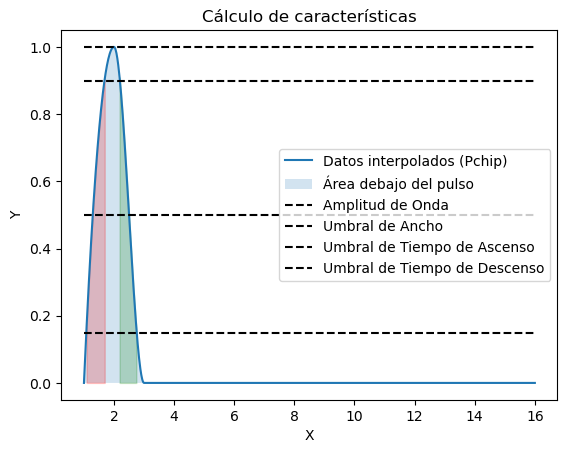

In [38]:
# Calcular todas las características
amplitude_value = amplitude(p(xnew))
width_value = width(p(xnew), 0.3)
rise_time_value, start_rise_index, end_rise_index = rise_time(p(xnew))
fall_time_value, start_fall_index, end_fall_index = fall_time(p(xnew))
area_value = area_under_pulse(xnew, p(xnew))
asc_slope = ascending_slope(xnew, p(xnew), start_rise_index, end_rise_index)
desc_slope = descending_slope(xnew, p(xnew), start_fall_index, end_fall_index)
energy = pulse_energy(xnew, p(xnew))
symmetry = pulse_symmetry(p(xnew), start_rise_index, end_rise_index, start_fall_index, end_fall_index)
bandwidth, significant_freqs, power_spectrum, xf, yf = calculate_bandwidth(xnew, p(xnew))

# Mostrar los resultados
print(f"Amplitud de Onda: {amplitude_value}")
print(f"Ancho del Pulso: {width_value}")
print(f"Tiempo de Ascenso: {rise_time_value}")
print(f"Tiempo de Descenso: {fall_time_value}")
print(f"Área debajo del pulso: {area_value}")
print(f"Pendiente del Borde Ascendente: {asc_slope}")
print(f"Pendiente del Borde Descendente: {desc_slope}")
print(f"Energía del Pulso: {energy}")
print(f"Simetría del Pulso: {symmetry}")
print(f"Ancho de Banda: {bandwidth}")

# Visualización
plt.plot(xnew, p(xnew), label='Datos interpolados (Pchip)')
plt.fill_between(xnew, p(xnew), alpha=0.2, label='Área debajo del pulso')
#plt.plot(xnew[start_rise_index:end_rise_index+1], p(xnew)[start_rise_index:end_rise_index+1], 'ro', label='Puntos de pendiente ascendente')
#plt.plot(xnew[start_fall_index:end_fall_index+1], p(xnew)[start_fall_index:end_fall_index+1], 'go', label='Puntos de pendiente descendente')
plt.plot(xnew, np.ones_like(xnew) * amplitude_value, 'k--', label='Amplitud de Onda')
plt.plot(xnew, np.ones_like(xnew) * (amplitude_value * 0.5), 'k--', label='Umbral de Ancho')
plt.plot(xnew, np.ones_like(xnew) * (amplitude_value * 0.15), 'k--', label='Umbral de Tiempo de Ascenso')
plt.plot(xnew, np.ones_like(xnew) * (amplitude_value * 0.9), 'k--', label='Umbral de Tiempo de Descenso')
plt.fill_between(xnew, p(xnew), where=(xnew >= xnew[start_rise_index]) & (xnew <= xnew[end_rise_index]), alpha=0.2, color='red')
plt.fill_between(xnew, p(xnew), where=(xnew >= xnew[start_fall_index]) & (xnew <= xnew[end_fall_index]), alpha=0.2, color='green')
plt.legend()
plt.title("Cálculo de características")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


## Guardado de Características

In [39]:
def calculate_features(x, y):
    amplitude_value = amplitude(y)
    width_value = width(y, 0.3)
    rise_time_value, start_rise_index, end_rise_index = rise_time(y)
    fall_time_value, start_fall_index, end_fall_index = fall_time(y)
    area_value = area_under_pulse(x, y)
    asc_slope = ascending_slope(x, y, start_rise_index, end_rise_index)
    desc_slope = descending_slope(x, y, start_fall_index, end_fall_index)
    energy = pulse_energy(x, y)
    symmetry = pulse_symmetry(y, start_rise_index, end_rise_index, start_fall_index, end_fall_index)
    bandwidth, significant_freqs, power_spectrum, xf, yf = calculate_bandwidth(x, y)

    features = {
        "amplitude": amplitude_value,
        "width": width_value,
        "rise_time": rise_time_value,
        "fall_time": fall_time_value,
        "area": area_value,
        "ascending_slope": asc_slope,
        "descending_slope": desc_slope,
        "energy": energy,
        "symmetry": symmetry,
        "bandwidth": bandwidth
    }

    return features

# # Interpolate and calculate features for each row
# features_list = []
# for index, row in data.head(1000).iterrows():
# #for index, row in data.iterrows():
#     y = row.values[1:]  # Skip the first column which is likely an index
#     x = np.arange(1, len(y) + 1)
    
#     mask = ~np.isnan(y)
#     p = PchipInterpolator(x[mask], y[mask])
#     xnew = np.linspace(1, len(y), num=1000)
#     ynew = p(xnew)
    
#     features = calculate_features(xnew, ynew)
#     features_list.append(features)

# # Convert the list of features to a DataFrame
# features_df = pd.DataFrame(features_list)
# features_df.to_csv("features.csv", index=False)

In [40]:
import os

# Get list of all data files in the folder
data_files = [f for f in os.listdir(folder) if f.endswith("-output.csv.gz")]

# Iterate over each data file, read it, calculate features, and save them as a compressed CSV
for data_file in data_files:
    # Read the data file
    data = pd.read_csv(os.path.join(folder, data_file), compression='gzip')
    
    # Interpolate and calculate features for each row
    features_list = []
    for index, row in data.iterrows():
        y = row.values[1:]  # Skip the first column which is likely an index
        x = np.arange(1, len(y) + 1)
        
        mask = ~np.isnan(y)
        p = PchipInterpolator(x[mask], y[mask])
        xnew = np.linspace(1, len(y), num=1000)
        ynew = p(xnew)
        
        features = calculate_features(xnew, ynew)
        features_list.append(features)
    
    # Convert the list of features to a DataFrame
    features_df = pd.DataFrame(features_list)
    
    # Define the output file name
    output_file = os.path.join(folder, data_file.replace(".csv.gz", "_features.csv.gz"))
    
    # Save the features as a compressed CSV
    features_df.to_csv(output_file, index=False, compression='gzip')
    print(f"Features saved to: {output_file}")

print("Compressed CSV files with features created successfully.")

Features saved to: /home/agustin/Documentos/Tesis/datos/40mhz/brc-2002_086400-01-output_features.csv.gz
Features saved to: /home/agustin/Documentos/Tesis/datos/40mhz/brc-2002_086400-21-output_features.csv.gz
Features saved to: /home/agustin/Documentos/Tesis/datos/40mhz/brc-2002_086400-17-output_features.csv.gz
Features saved to: /home/agustin/Documentos/Tesis/datos/40mhz/brc-2002_086400-20-output_features.csv.gz
Features saved to: /home/agustin/Documentos/Tesis/datos/40mhz/brc-2002_086400-14-output_features.csv.gz
Features saved to: /home/agustin/Documentos/Tesis/datos/40mhz/brc-2002_086400-19-output_features.csv.gz
Features saved to: /home/agustin/Documentos/Tesis/datos/40mhz/brc-2002_086400-22-output_features.csv.gz
Features saved to: /home/agustin/Documentos/Tesis/datos/40mhz/brc-2002_086400-16-output_features.csv.gz
Features saved to: /home/agustin/Documentos/Tesis/datos/40mhz/brc-2002_086400-11-output_features.csv.gz
Features saved to: /home/agustin/Documentos/Tesis/datos/40mhz/br